# Notebook version of QAOA

In [ ]:
pip install 

In [19]:
# pip install qsharp


In [18]:
# pip install qsharp_widgets

In [20]:
# This Notebook acts as a host for Q# to implement Quantum Approximate Optimization Algorithm (QAOA) on a gate-based Quantum Computing model.

# Importing required libraries
# General imports
import time
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

# Libraries for Model Formulation
from docplex.mp.model import Model
from scipy.optimize import minimize

# Qiskit Imports
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp

# Qsharp
import qsharp
from qsharp_widgets import EstimatesOverview

ModuleNotFoundError: No module named 'qiskit.exceptions'

In [15]:
# Defining helper functions.
def find_most_common_solutions(input_dict, n):
    """
    Sorts the keys of the input dictionary in descending order based on their values and returns the first n keys.

    Parameters:
        input_dict (dict): A dictionary containing the keys and their corresponding values.
        n (int): The number of most common solutions to return.

    Returns:
        list: A list of the n most common keys sorted in descending order based on their values.
    """
    sorted_keys = sorted(input_dict, key=input_dict.get, reverse=True)
    return sorted_keys[:n]


# Building the model and its Cost Function
def build_qubo(arr: list):
    """
    Function to build a QUBO (Quadratic Unconstrained Binary Optimization) model from a given array
    for the Number Partitioning Problem (NPP).

    :param arr: a list of integers representing the array from which the QUBO model is built
    :return: a tuple containing the quadratic coefficients, linear coefficients, and the QUBO model
    """

    # Length of the array - Length of the binary vector x
    n = len(arr)
    # Sum of the array - c
    c = sum(arr)

    # Building the model and its QUBO formulation.
    model = Model()
    x = model.binary_var_list(n)

    # Cost Function for Number Partirioning Problem (NPP)
    Q =  (c - 2*sum(arr[i]*x[i] for i in range(n)))**2
    model.minimize(Q)   
    problem = from_docplex_mp(model)

    # QUBO formulation
    converter = QuadraticProgramToQubo()
    qubo = converter.convert(problem)

    # Quadratic and Linear Coefficients
    quadratics = qubo.objective.quadratic.coefficients
    linears = qubo.objective.linear.coefficients

    return quadratics, linears, qubo

def interger_to_counts(n: int, result: list) -> dict:
    """
    Given a list of integers (output of the circuit), returns a dictionary with the counts of each integer.

    Args:
        n (int): The number of qubits in the circuit. Width of the bitstring.
        a (list): The integer array to be converted.

    Returns:
        dict: A dictionary representing the counts of the integers (bitstrings).

    Example:
        >>> interger_to_counts(2 ,[1, 2, 3, 2, 1, 0])
        {'00': 1, '01': 2, '10': 1, '11': 0}
    """
    counts = {}
    for i in range(2**n):
        counts[np.binary_repr(i,width=n)] = 0
    for integer in result:
        counts[np.binary_repr(integer,width=n)] += 1
    return counts

def arr_to_str(a: np.ndarray) -> str:
    """
    Converts a given array to a string representation.

    Args:
        a (list): The array to be converted.

    Returns:
        str: The string representation of the array.

    Example:
        >>> arr_to_str([1, 2, 3])
        '[1, 2, 3]'
    """
    string =''
    for i in a:
        string += str(i) + ","
    return '[' + string[:-1] + ']'

In [16]:
%%qsharp
// This is a program for simulating the QAOA circuit. 
namespace qaoa_note{

    open Microsoft.Quantum.Measurement;

    // Function for getting flat index
    operation flat_index(n: Int, i: Int, j: Int): Int{
        return n*i + j
    }
    // Cost Hamiltonian
    operation cost_unitary(qubits: Qubit[], gamma: Double, quadratics: Double[], linears: Double[]): Unit{
        
        let n_qubits = Length(linears);
        mutable quad_sum : Double = 0.0;

        // RZ Gates
        for qubit in 0..n_qubits-1{
            set quad_sum = 0.0;
            for quad_qubit in 0..n_qubits-1{
                set quad_sum += quadratics[flat_index(n_qubits,qubit,quad_qubit)];
            }
            Rz(0.5 * (linears[qubit] + quad_sum) * gamma, qubits[qubit])
        }
        // RZZ Gates
        for i in 0..n_qubits-1{
            for j in i+1..n_qubits-1{                
                Rzz(0.25 * quadratics[flat_index(n_qubits,i,j)] * gamma, qubits[i], qubits[j])
            }
        }
    }

    // Mixer Hamiltonian
    operation mixer_unitary(qubits: Qubit[], beta: Double) : Unit{
        for qubit in qubits{
            Rx(2.0 * beta,qubit);
        }
    }

    // Function to create the QAOA circuit.
    operation circuit(NQubits: Int, Layers: Int, gammas: Double[], betas: Double[], quadratics: Double[], linears: Double[]) : Int {

        use q = Qubit[NQubits]; 
        mutable integer_result = 0;
        
        // State Preparation |+>
        ApplyToEachA(H,q);

        for layer in 0..Layers-1{
            mixer_unitary(q, betas[layer]);
            cost_unitary(q, gammas[layer], quadratics, linears)
        }
        // Return the bitstring as an integer.
        return MeasureInteger(q);
    }
}


In [17]:
func_call = 0
theta = []
cost = []

def callback_func(x):
    theta.append(x)

def qaoa_NPP(arr,layers:int):
    
    quadratics, linears, qubo = build_qubo(arr)
    num_qubits = len(arr)

    quadratics = quadratics.toarray().flatten()
    linears = linears.toarray()

    # Initial guess
    init_gamma = np.array([pi/1.5]*layers)
    init_beta = np.array([pi/4]*layers)
    initial_guess = np.concatenate((init_gamma, init_beta))
    
    def expectation_value(theta):
        global func_call 
        func_call = func_call + 1
        print(f'Function call: {func_call}')
        middle = int(len(theta)/2)
        gammas = theta[:middle]
        betas = theta[middle:]

        input_str = f"{num_qubits},{layers},{arr_to_str(gammas)},{arr_to_str(betas)},{arr_to_str(quadratics)},{arr_to_str(linears[0])}"

        int_results = qsharp.run(f"qaoa_note.circuit({input_str})",shots=100)
        counts = interger_to_counts(num_qubits,int_results)

        best_sol = max(counts, key=counts.get) # type: ignore
        exp =  qubo.objective.evaluate(np.array(list(best_sol), dtype='int'))
        cost.append(exp)
        return exp

    # Minimization of the objective function.
    start_time = time.time()
    res = minimize(expectation_value, initial_guess, method='COBYLA',callback=callback_func)
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f'Elapsed time for QAOA: {elapsed_time} seconds')

    middle = int(len(res.x)/2)
    prime_gammas = res.x[:middle]
    prime_betas = res.x[middle:]

    input_str = f"{num_qubits},{layers},{arr_to_str(prime_gammas)},{arr_to_str(prime_betas)},{arr_to_str(quadratics)},{arr_to_str(linears[0])}"

    results = qsharp.run(f"qaoa_note.circuit({input_str})",shots=100)
    
    counts = interger_to_counts(num_qubits,results)
    
    return counts

# Defining a test array
test_array = [5,1,6]
layers = 2

# Running QAOA on for Number Partitioning.
counts = qaoa_NPP(test_array,layers)

NameError: name 'from_docplex_mp' is not defined

In [4]:
# Plotting the output state.
plt.figure(figsize=(15, 5))
plt.bar(range(len(counts)), list(counts.values()), align='center', color='red')
plt.xticks(range(len(counts)), list(counts.keys()), rotation=90)
plt.title("QAOA Output State")
plt.xlabel("Bitstrings")
plt.ylabel("Counts")
plt.grid()
plt.show()

NameError: name 'counts' is not defined

<Figure size 1500x500 with 0 Axes>

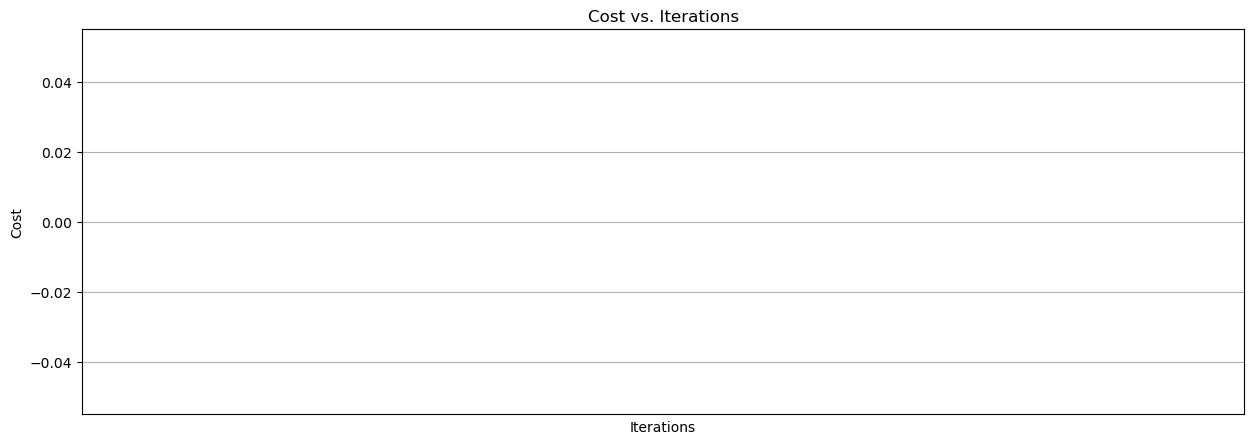

In [5]:
# Plotting Cost vs. iterations.
plt.figure(figsize=(15, 5))
plt.plot(range(len(cost)),cost,color='g',ls='--',marker='o',lw=2)
plt.xticks(range(1,len(cost)+1,5))
plt.title('Cost vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid()
plt.show()

In [9]:
best_sol = find_most_common_solutions(counts,3)
print(f'\nQAOA Top 3 solutions for {test_array} and {layers} layers: \n{best_sol}')

c = sum(test_array)
S = []
S_A = []
for ind,bit in enumerate(best_sol[0]):
    if bit == '1':
        S.append(ind)
    else:
        S_A.append(ind)

sum_S = sum(np.array(test_array)[S])
sum_S_A = sum(np.array(test_array)[S_A])    

print(f'\n\n Best partition:\nS {np.array(test_array)[S]} - Sum(S) = {sum_S}\nS/A {np.array(test_array)[S_A]} - Sum(S/A) = {sum_S_A}')


QAOA Top 3 solutions for [5, 1, 6] and 2 layers: 
['001', '101', '010']


 Best partition:
S [6] - Sum(S) = 6
S/A [5 1] - Sum(S/A) = 6


## Using the Resourse Estimator

In [13]:
test_array = [1,2,4]

n = len(test_array)
layers = 3

quadratics, linears, qubo = build_qubo(test_array)
quadratics = quadratics.toarray().flatten()
linears = linears.toarray()

gammas = np.random.rand(layers)
betas = np.random.rand(layers)

input_str = f"{n},{layers},{arr_to_str(gammas)},{arr_to_str(betas)},{arr_to_str(quadratics)},{arr_to_str(linears[0])}"


In [14]:
#below this cell is the testing and changing of parameters

In [47]:

result = qsharp.estimate(f"qaoa_note.circuit({input_str})", params={"errorBudget": 0.01, "qubitParams": {"name": "qubit_maj_ns_e6"}, "qecScheme": {"name": "floquet_code"},"estimateType": "frontier", "constraints": {"logicalDepthFactor": 4}})

estimates_overview = EstimatesOverview(result)
estimates_overview

EstimatesOverview(estimates={'status': 'success', 'jobParams': {'qecScheme': {'name': 'floquet_code', 'errorCo…

In [46]:
from qsharp.estimator import EstimatorParams, QubitParams, QECScheme

labels = ["Gate-based µs, 10⁻³", "Gate-based µs, 10⁻⁴", "Gate-based ns, 10⁻³", "Gate-based ns, 10⁻⁴", "F-Majorana ns, 10⁻⁴", "F-Majorana ns, 10⁻⁶", "S-Majorana ns, 10⁻⁴", "S-Majorana ns, 10⁻⁶"]

params = EstimatorParams(num_items=8)
params.error_budget = 0.333
params.items[0].qubit_params.name = QubitParams.GATE_US_E3
params.items[0].qubit_params.estimateType = "frontier"
params.items[1].qubit_params.name = QubitParams.GATE_US_E4
params.items[1].qubit_params.estimateType = "frontier"
params.items[2].qubit_params.name = QubitParams.GATE_NS_E3
params.items[2].qubit_params.estimateType = "frontier"
params.items[3].qubit_params.name = QubitParams.GATE_NS_E4
params.items[3].qubit_params.estimateType = "frontier"
params.items[4].qubit_params.name = QubitParams.MAJ_NS_E4
params.items[4].qubit_params.estimateType = "frontier"
params.items[4].qec_scheme.name = QECScheme.FLOQUET_CODE
params.items[5].qubit_params.name = QubitParams.MAJ_NS_E6
params.items[5].qubit_params.estimateType = "frontier"
params.items[5].qec_scheme.name = QECScheme.FLOQUET_CODE
params.items[6].qubit_params.name = QubitParams.MAJ_NS_E4
params.items[6].qubit_params.estimateType = "frontier"
params.items[6].qec_scheme.name = QECScheme.SURFACE_CODE
params.items[7].qubit_params.name = "qubit_maj_ns_e6"
params.items[7].qec_scheme.name = QECScheme.SURFACE_CODE
params.items[7].qubit_params.estimateType = "frontier"


# results = qsharp.estimate(f"qaoa_note.circuit({input_str})", params=params).summary_data_frame(labels=labels)
# display(results[:])

result = qsharp.estimate(f"qaoa_note.circuit({input_str})", params=params)

estimates_overview = EstimatesOverview(result,runNames=labels)
estimates_overview

EstimatesOverview(estimates={0: {'status': 'success', 'jobParams': {'qecScheme': {'name': 'surface_code', 'err…

In [44]:
result = qsharp.estimate(
    f"qaoa_note.circuit({input_str})", 
    params=[
        {
            "error_budget": 0.333,
            "qubitParams": { "name": "qubit_gate_ns_e3" },
            "qecScheme": { "name": "surface_code" },
            "estimateType": "frontier", # Pareto frontier estimation
        },
        {
            "error_budget": 0.333,
            "qubitParams": { "name": "qubit_gate_ns_e4" },
            "qecScheme": { "name": "surface_code" },
            "estimateType": "frontier", # Pareto frontier estimation
        },
        {
            "error_budget": 0.333,
            "qubitParams": { "name": "qubit_gate_us_e3" },
            "qecScheme": { "name": "surface_code" },
            "estimateType": "frontier", # Pareto frontier estimation
        },
        {
            "error_budget": 0.333,
            "qubitParams": { "name": "qubit_gate_us_e4" },
            "qecScheme": { "name": "surface_code" },
            "estimateType": "frontier", # Pareto frontier estimation
        },
        {
            "error_budget": 0.333,
            "qubitParams": { "name": "qubit_maj_ns_e4" },
            "qecScheme": { "name": "surface_code" },
            "estimateType": "frontier", # Pareto frontier estimation
        },
        {
            "error_budget": 0.333,
            "qubitParams": { "name": "qubit_maj_ns_e4" },
            "qecScheme": { "name": "floquet_code" },
            "estimateType": "frontier", # Pareto frontier estimation
        },
        {
            "error_budget": 0.333,
            "qubitParams": { "name": "qubit_maj_ns_e6" },
            "qecScheme": { "name": "surface_code" },
            "estimateType": "frontier", # Pareto frontier estimation
        },
        {
            "error_budget": 0.333,
            "qubitParams": { "name": "qubit_maj_ns_e6" },
            "qecScheme": { "name": "floquet_code" },
            "estimateType": "frontier", # Pareto frontier estimation
        }
    ]
)

runNames = [
    "Gate-based µs, 10⁻³", "Gate-based µs, 10⁻⁴",
    "Gate-based ns, 10⁻³", "Gate-based ns, 10⁻⁴",
    "S-Majorana ns, 10⁻⁴", "F-Majorana ns, 10⁻⁴",
    "S-Majorana ns, 10⁻⁶", "F-Majorana ns, 10⁻⁶"
]

EstimatesOverview(result, runNames=runNames)


EstimatesOverview(estimates={0: {'status': 'success', 'jobParams': {'qecScheme': {'name': 'surface_code', 'err…